## Data Exploration
#### Data Source

The dataset was collected through surveys by the Central Bureau of Statistics that work under the National Planning Commission Secretariat of Nepal. This survey is one of the largest post-disaster datasets ever collected, containing valuable information on earthquake impacts, household conditions, and socio-economic-demographic statistics.  The datasets have been downloaded from https://www.kaggle.com/mullerismail/richters-predictor-modeling-earthquake-damage

The goal is to predict the level of damage to buildings caused by the 2015 Gorkha earthquake in Nepal. The ordinal variable `damage_grade`, which represents a level of damage to the building that was hit by the earthquake. There are 3 grades of the damage:


- `1` represents `low damage`
- `2` represents `medium amount of damage`
- `3` represents `almost complete destruction`

In [1]:
import numpy as np # import numpy library
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# disable chained assignments
pd.options.mode.chained_assignment = None 

from pyspark.sql.functions import mean, min, max
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from matplotlib.pyplot import figure

%matplotlib inline

pd.set_option("display.max_columns", None)

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190711083829-0000
KERNEL_ID = 0bc830cb-d013-40d9-adc4-e9e566218b75


## Data Extraction & Loading

In [2]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-1ffa7090-b46d-409d-a4c2-d72608483d6a',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token',
    'api_key': 'rJ9gWSE1VMXj0qVCzTfP36owXVp9NrU3vaRpVRtcgyz3'
}

configuration_name = 'os_e69b22554ae141c3a275fabb55b0f50e_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
train_values = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferschema', 'true')\
  .load(cos.url('train_values.csv', 'advanceddatasciencewithibm-donotdelete-pr-z8s5dzzkvq4bck'))
train_values.createOrReplaceTempView("train_values")

# display first 5 rows, with scroll like in Pandas df
#train_values.show(5)
train_values.limit(5).toPandas().head()


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [3]:
# how many rows & columns? 
print((train_values.count(), len(train_values.columns)))

# column types?
train_values.dtypes

(260601, 39)


[('building_id', 'int'),
 ('geo_level_1_id', 'int'),
 ('geo_level_2_id', 'int'),
 ('geo_level_3_id', 'int'),
 ('count_floors_pre_eq', 'int'),
 ('age', 'int'),
 ('area_percentage', 'int'),
 ('height_percentage', 'int'),
 ('land_surface_condition', 'string'),
 ('foundation_type', 'string'),
 ('roof_type', 'string'),
 ('ground_floor_type', 'string'),
 ('other_floor_type', 'string'),
 ('position', 'string'),
 ('plan_configuration', 'string'),
 ('has_superstructure_adobe_mud', 'int'),
 ('has_superstructure_mud_mortar_stone', 'int'),
 ('has_superstructure_stone_flag', 'int'),
 ('has_superstructure_cement_mortar_stone', 'int'),
 ('has_superstructure_mud_mortar_brick', 'int'),
 ('has_superstructure_cement_mortar_brick', 'int'),
 ('has_superstructure_timber', 'int'),
 ('has_superstructure_bamboo', 'int'),
 ('has_superstructure_rc_non_engineered', 'int'),
 ('has_superstructure_rc_engineered', 'int'),
 ('has_superstructure_other', 'int'),
 ('legal_ownership_status', 'string'),
 ('count_families',

### load the train_labels dataset which contains the `damage_grade` target variable

In [4]:
train_labels = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferschema', 'true')\
  .load(cos.url('train_labels.csv', 'advanceddatasciencewithibm-donotdelete-pr-z8s5dzzkvq4bck'))

# display first 5 rows, with scroll like in Pandas df
#train_labels.take(5)
train_labels.limit(5).toPandas().head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [5]:
# how many rows & columns? 
print((train_labels.count(), len(train_labels.columns)))

(260601, 2)


In [6]:
# column types?
train_labels.dtypes

[('building_id', 'int'), ('damage_grade', 'int')]

### The total number of rows in both datasets is the same (`260,601`) and both shared the common column, `building_id`
Join the two datasets on `building_id`, drop the duplicate column to form new dataset, `train_data`

In [7]:
train_data = train_values.join(train_labels, train_values.building_id == train_labels.building_id).drop(train_labels.building_id)

print((train_data.count(), len(train_data.columns)))
train_data.dtypes

(260601, 40)


[('building_id', 'int'),
 ('geo_level_1_id', 'int'),
 ('geo_level_2_id', 'int'),
 ('geo_level_3_id', 'int'),
 ('count_floors_pre_eq', 'int'),
 ('age', 'int'),
 ('area_percentage', 'int'),
 ('height_percentage', 'int'),
 ('land_surface_condition', 'string'),
 ('foundation_type', 'string'),
 ('roof_type', 'string'),
 ('ground_floor_type', 'string'),
 ('other_floor_type', 'string'),
 ('position', 'string'),
 ('plan_configuration', 'string'),
 ('has_superstructure_adobe_mud', 'int'),
 ('has_superstructure_mud_mortar_stone', 'int'),
 ('has_superstructure_stone_flag', 'int'),
 ('has_superstructure_cement_mortar_stone', 'int'),
 ('has_superstructure_mud_mortar_brick', 'int'),
 ('has_superstructure_cement_mortar_brick', 'int'),
 ('has_superstructure_timber', 'int'),
 ('has_superstructure_bamboo', 'int'),
 ('has_superstructure_rc_non_engineered', 'int'),
 ('has_superstructure_rc_engineered', 'int'),
 ('has_superstructure_other', 'int'),
 ('legal_ownership_status', 'string'),
 ('count_families',

## Initial Data Exploration
We will create a Pandas dataframe for the rest of the exploratory data analysis

In [8]:
# convert to pandas dataframe for descriptive visualizations
df = train_data.toPandas()

# check resultant data frame size
df.shape

(260601, 40)

In [9]:
df.dtypes

building_id                                int32
geo_level_1_id                             int32
geo_level_2_id                             int32
geo_level_3_id                             int32
count_floors_pre_eq                        int32
age                                        int32
area_percentage                            int32
height_percentage                          int32
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int32
has_superstructure_mud_mortar_stone        int32
has_superstructure_stone_flag              int32
has_superstructure_cement_mortar_stone     int32
has_superstructure_mud_mortar_brick        int32
has_superstructure_c

In [10]:
# select list of columns with at least 1 NaN values to confirm if there is any missing data in all the columns
df.columns[df.isna().any()].tolist()

[]

In [11]:
#Create lists of numeric & categorical column names
def get_type_lists(data_frame=df, rejects=['building_id','damage_grade']):
    nums, cats = [], []

    for col in data_frame.columns:
        if col not in rejects:
            type=data_frame[col].dtype
            if type in ('int64','int32','float64') :
                nums.append(col)
            elif str(type) in ('object')  :
                cats.append(col)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

nums, cats = get_type_lists()

Numeric = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 'count_families', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']

Categorical = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_c

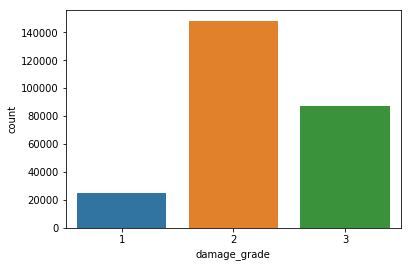

In [12]:
# plot bar chart of the No. of buildings by Damage Grade
sns.countplot(x='damage_grade', data=df)

In [13]:
# describe numerical columns
stats_df = df[nums]

# how many labels in each variable
for col in stats_df.columns:
    print(col, ': ', len(stats_df[col].unique()), ' labels')

geo_level_1_id :  31  labels
geo_level_2_id :  1414  labels
geo_level_3_id :  11595  labels
count_floors_pre_eq :  9  labels
age :  42  labels
area_percentage :  84  labels
height_percentage :  27  labels
has_superstructure_adobe_mud :  2  labels
has_superstructure_mud_mortar_stone :  2  labels
has_superstructure_stone_flag :  2  labels
has_superstructure_cement_mortar_stone :  2  labels
has_superstructure_mud_mortar_brick :  2  labels
has_superstructure_cement_mortar_brick :  2  labels
has_superstructure_timber :  2  labels
has_superstructure_bamboo :  2  labels
has_superstructure_rc_non_engineered :  2  labels
has_superstructure_rc_engineered :  2  labels
has_superstructure_other :  2  labels
count_families :  10  labels
has_secondary_use :  2  labels
has_secondary_use_agriculture :  2  labels
has_secondary_use_hotel :  2  labels
has_secondary_use_rental :  2  labels
has_secondary_use_institution :  2  labels
has_secondary_use_school :  2  labels
has_secondary_use_industry :  2  labe

In [14]:
# show summary statistics for the numerical variables
stats_df.describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,0.018235,0.068154,0.075268,0.254988,0.085011,0.042590,0.015859,0.014985,0.983949,0.111880,0.064378,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119
std,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,0.133800,0.252010,0.263824,0.435855,0.278899,0.201931,0.124932,0.121491,0.418389,0.315219,0.245426,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The columns with names beginning `'has_superstructure'` and `'has_secondary_use'` are binary variables, having `0` for True and `1` for False

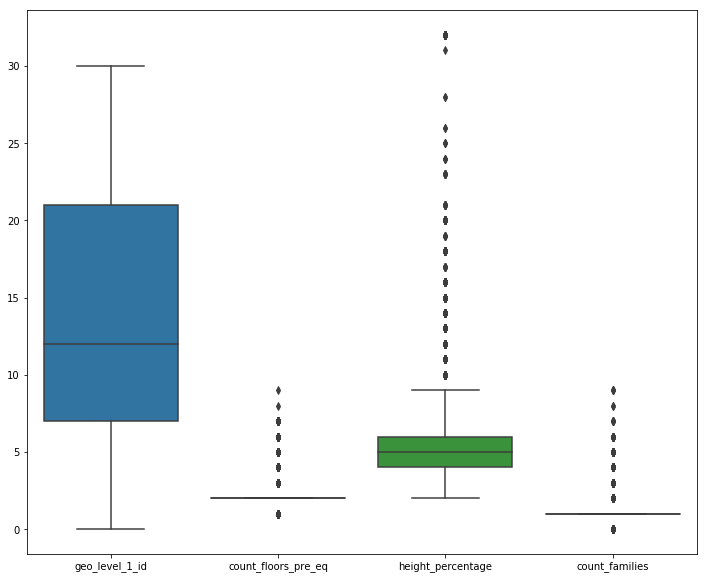

In [15]:
# Pre-format DataFrame to contain selected columns with comparable ranges
stats_df = df[['geo_level_1_id','count_floors_pre_eq','height_percentage','count_families']]

# New boxplot using stats_df
plt.figure(figsize=(12,10))
sns.boxplot(data=stats_df)

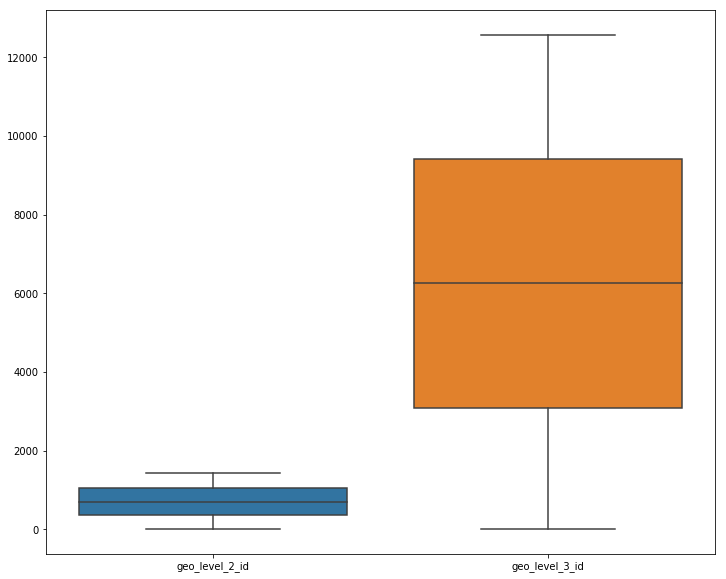

In [16]:
# Pre-format DataFrame to contain selected columns with comparable ranges
stats_df = df[['geo_level_2_id','geo_level_3_id']]

# New boxplot using stats_df
plt.figure(figsize=(12,10))
sns.boxplot(data=stats_df)

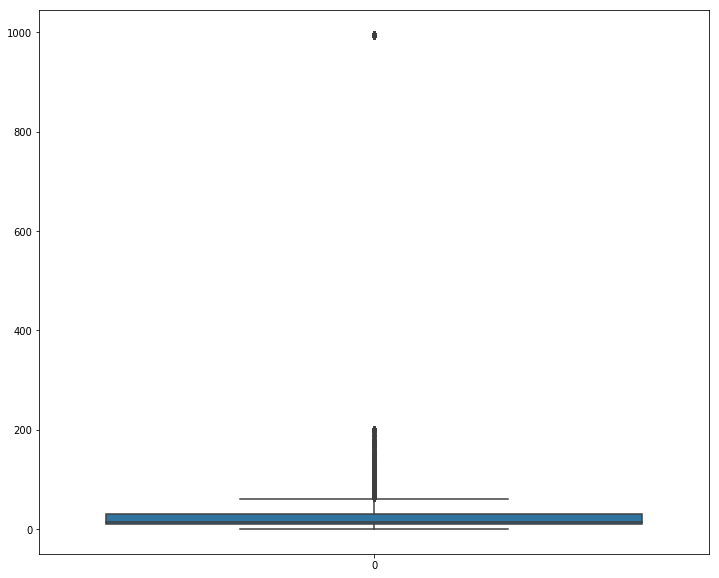

In [17]:
# Pre-format DataFrame to contain selected columns
stats_df = df.loc[:, 'age']

# New boxplot using stats_df
plt.figure(figsize=(12,10))
sns.boxplot(data=stats_df)

There seems be an extreme outlier value in the 900s in the age column. Let's confirm the count.

In [18]:
print(len(df[df['age'] > 200]), ' out of ',len(df), " constitutes ", '{:.3f}'.format(len(df[df['age'] > 200])/len(df)), '%')

1390  out of  260601  constitutes  0.005 %


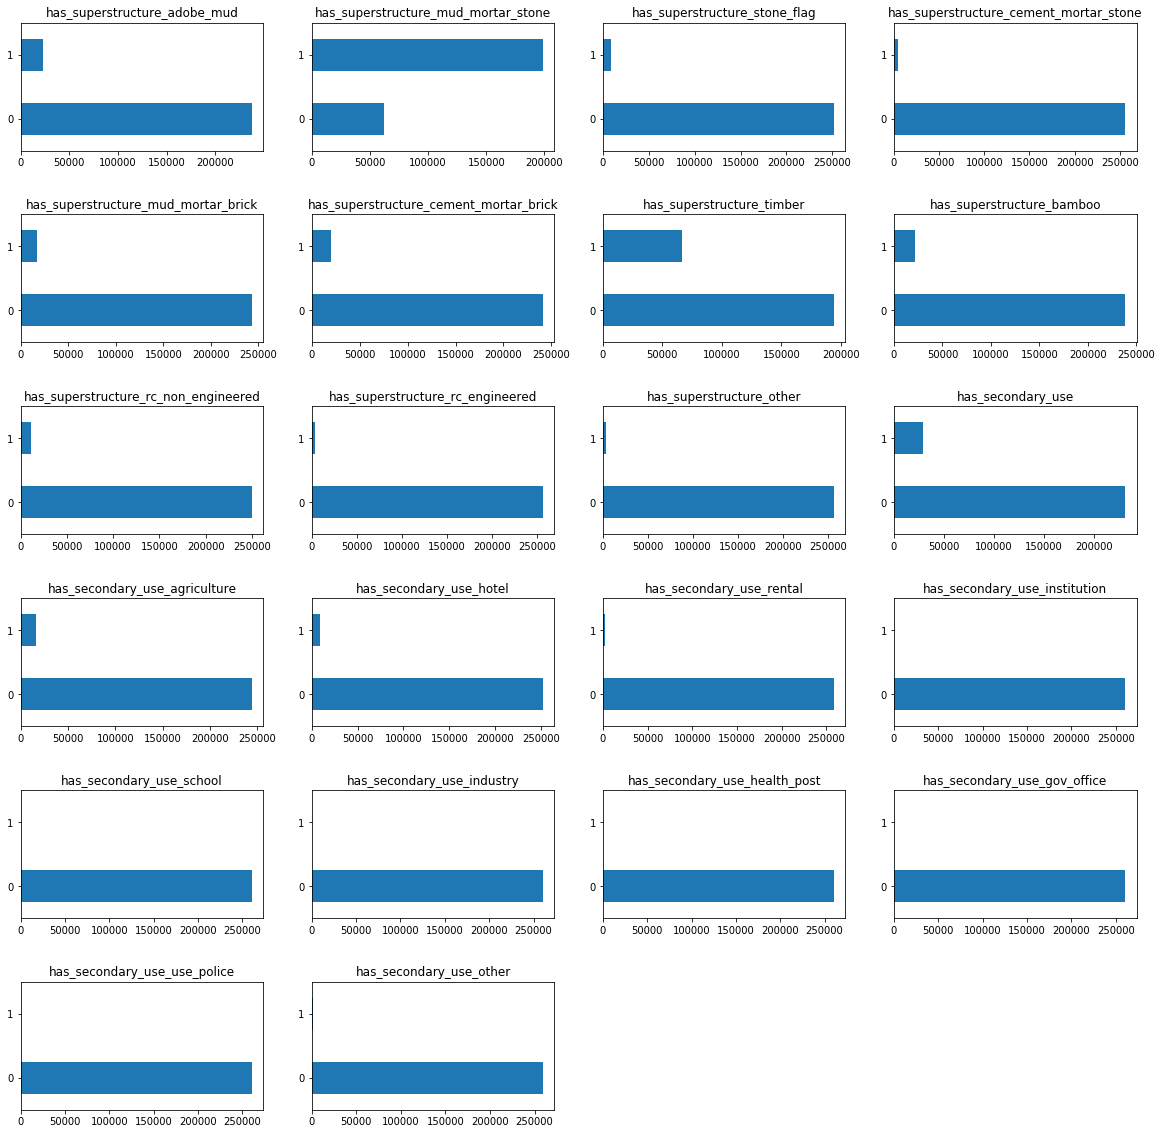

In [19]:
# plot distribution of the "binary" numerical variables
bin_cols = []

for col in df[nums].columns:
    if col[:4]=="has_":
       bin_cols.append(col)

plt.rcParams["figure.figsize"] = [20, 20]
plt.subplots_adjust(hspace=0.5)
for i in range(1, 23):
    plt.subplot(6, 4, i)
    plt.title(bin_cols[i-1])
    df[bin_cols[i-1]].value_counts(sort=False).plot(kind='barh')    

Check exclusivity of the `has_superstructure` columns by totalling the individual columns and displaying the sum of the total columm. 

In [20]:
stats_df = df[[c for c in df.columns if c.startswith('has_superstructure_')]]

stats_df['has_superstructure_total'] = stats_df.sum(axis=1)

pd.DataFrame({'Percentage': stats_df.groupby('has_superstructure_total').size() / len(stats_df)})

,Percentage
has_superstructure_total,
1,0.675423
2,0.221941
3,0.077552
4,0.018899
5,0.004831
6,0.001205
7,0.000134
8,0.000015


From the distinct total counts of the `has_superstructure_total` column, we can conclude that the individual `has_superstructure` columns are exclusive of each other.  In a building, any combinations of the flags/indicators can be found.  The maximum value of 8 shows that building can check off 8 out of the possible 11 `has_superstructure` column setttings.

Check exclusivity of the `has_secondary_use_` columns by totalling the individual columns and comparing the sum of them against the `has_secondary_use` column.

In [21]:
stats_df = df[[c for c in df.columns if c.startswith('has_secondary_use_')]]

stats_df['has_secondary_use_total'] = stats_df[[c for c in df.columns if c.startswith('has_secondary_use_')]].sum(axis=1)

pd.DataFrame({'Percentage': stats_df.groupby('has_secondary_use_total').size() / len(stats_df)})


,Percentage
has_secondary_use_total,
0,0.888120
1,0.109742
2,0.002137


The `has_secondary_use` columns are mutually exclusive of each other (as shown by `0` & `1` counts) for 99.8% of the records.

In [22]:
# count number and instances of each categorical variable
stats_df = df[cats]

for col in stats_df.columns:
    print(col, ': ', len(stats_df[col].unique()), ' labels',' values ',stats_df[col].unique().tolist())

land_surface_condition :  3  labels  values  ['t', 'o', 'n']
foundation_type :  5  labels  values  ['r', 'w', 'i', 'u', 'h']
roof_type :  3  labels  values  ['n', 'q', 'x']
ground_floor_type :  5  labels  values  ['f', 'x', 'v', 'z', 'm']
other_floor_type :  4  labels  values  ['q', 'x', 'j', 's']
position :  4  labels  values  ['t', 's', 'j', 'o']
plan_configuration :  10  labels  values  ['d', 'u', 's', 'q', 'm', 'c', 'a', 'n', 'f', 'o']
legal_ownership_status :  4  labels  values  ['v', 'a', 'r', 'w']


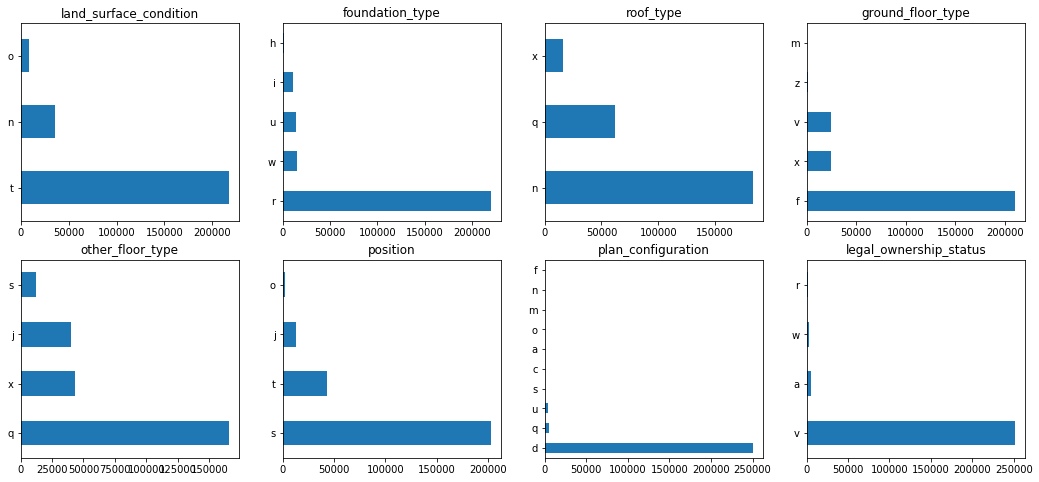

In [23]:
# plot distribution of the categorical variables

plt.rcParams["figure.figsize"] = [18, 8]
for i in range(1, 9):
    plt.subplot(2, 4, i)
    plt.title(cats[i-1])
    df[cats[i-1]].value_counts().plot(kind='barh')    


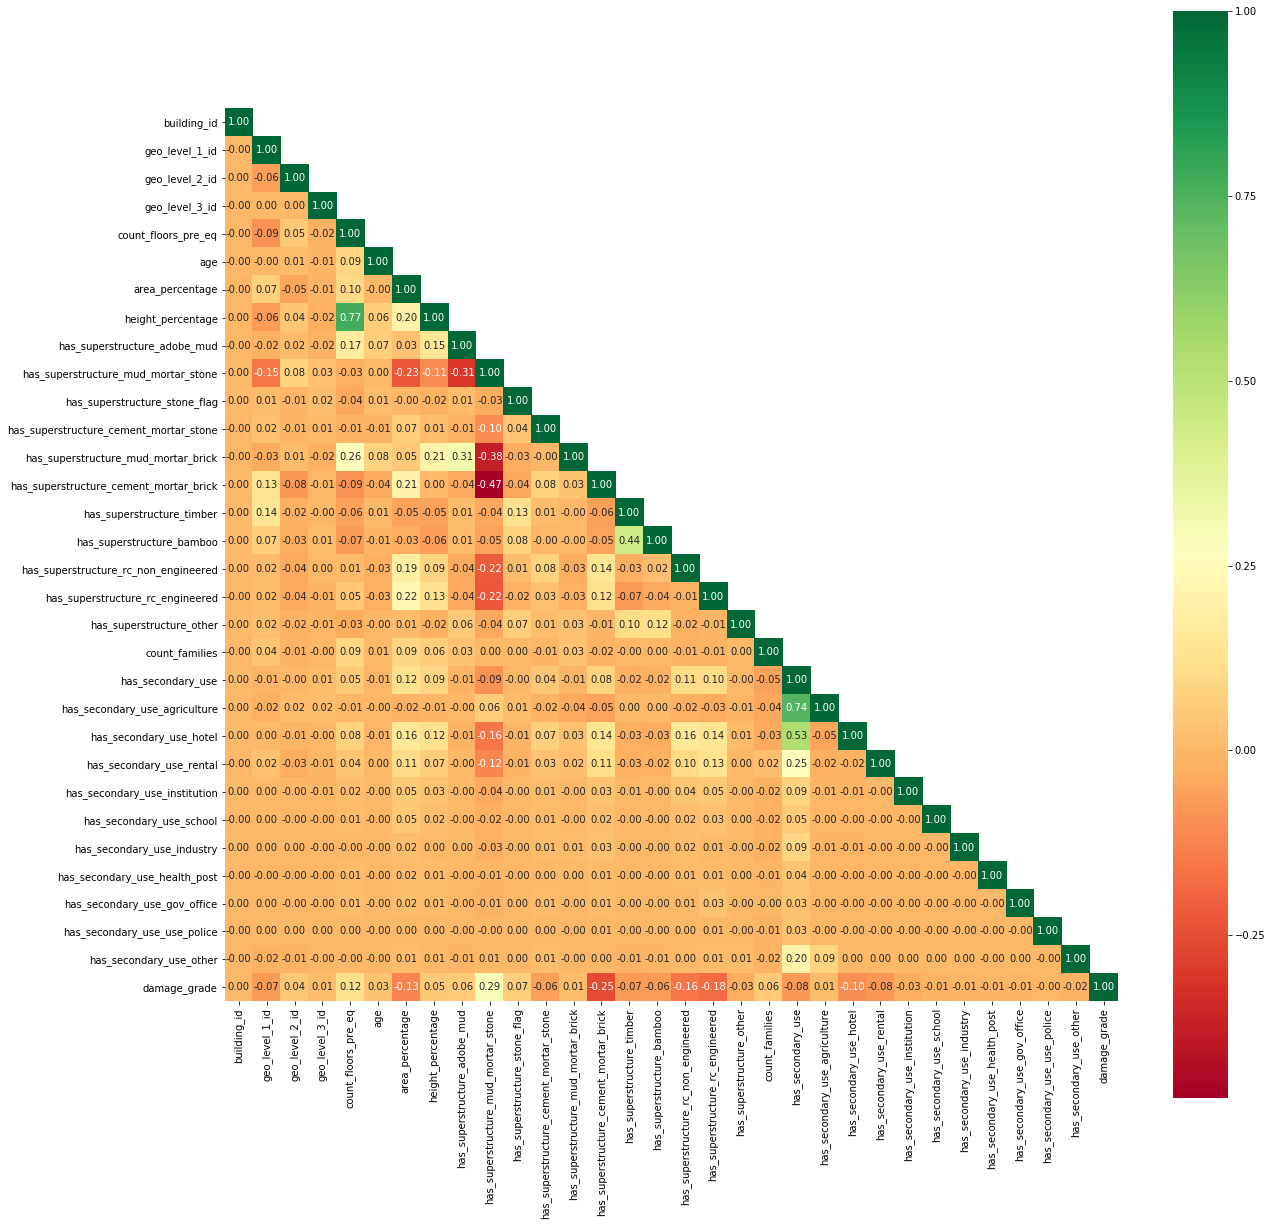

In [24]:
# look at correlation of variables
X = df[nums]        #independent columns
y = df.iloc[:,-1]    #target column i.e price range
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
mask = np.array(corrmat)
mask[np.tril_indices_from(mask)] = False
g=sns.heatmap(df[top_corr_features].corr(),mask=mask,annot=True,square=True,cmap="RdYlGn",fmt=".2f")

### Store Merged Data set in IBM Object Store
We will now save our Train_Data into the IBM Object store for us to be able to use it in the next Feature Engineering stage of the process.

In [25]:
train_data = train_data.repartition(1)
train_data.write.mode('overwrite').parquet(cos.url('Train_Data.parquet', 'advanceddatasciencewithibm-donotdelete-pr-z8s5dzzkvq4bck'))


Check and confirm that the persisted data in IBM Data Store is good.

In [26]:
df2 = spark.read.parquet(cos.url('Train_Data.parquet', 'advanceddatasciencewithibm-donotdelete-pr-z8s5dzzkvq4bck'))
print('Number of rows/columns read = ', (df2.count(), len(df2.columns)))
df2.limit(5).toPandas().head()

Number of rows/columns read =  (260601, 40)


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,299215,8,145,9305,3,15,5,8,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,377492,26,619,11605,2,15,7,5,t,r,n,f,q,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,1
2,294802,20,385,10589,2,15,11,6,o,w,q,f,q,s,d,0,1,1,0,0,0,1,1,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,3
3,843787,21,873,11921,3,45,4,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,0,1,1,0,0,0,0,0,0,0,0,0,3
4,343815,17,421,9044,3,20,15,8,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
